In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.dataset_slice_detector import create_dataset
from config.config import config
from common.dslices.config import config as sd_config

from utils.dslices.exper_handler import ExperHandlerEnsemble, ExperimentHandler as ExperimentHandlerSD
from utils.dslices.exper_handler import get_experiment_handlers

from models.slice_detector import DegenerateSliceDetector
from utils.dslices.batch_handler import BatchHandler as BatchHandlerSD

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(sd_config.exper_dict_brier)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. 
TEST_FOLD = 0

exp_hdl_emap_dict, exp_hdl_no_emap_dict, exp_hdl_umap_dict, exp_hdl_no_umap_dict = \
    get_experiment_handlers(ROOT_DIR, load_fold_id=TEST_FOLD, seg_exper_ensemble=seg_exper_ensemble)

expers = []
if len(exp_hdl_emap_dict) >= 1:
    exp_hdl_emap = exp_hdl_emap_dict.values()[0]
    expers.append(exp_hdl_emap.exper)
if len(exp_hdl_no_emap_dict) >= 1:
    exp_hdl_no_emap = exp_hdl_no_emap_dict.values()[0]
    expers.append(exp_hdl_no_emap.exper)
if len(exp_hdl_umap_dict) >= 1:
    exp_hdl_umap = exp_hdl_umap_dict.values()[0]
    expers.append(exp_hdl_umap.exper)
if len(exp_hdl_no_umap_dict) >= 1:
    exp_hdl_no_umap = exp_hdl_no_umap_dict.values()[0]
    expers.append(exp_hdl_no_umap.exper)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier
IMPORTANT INFO - Config key consists of #epoch, batch_size, backward_freq, weight_decay, lambda, lr

----------- Load experiment 20180829_17_45_49_sdvgg11_bn_f0p01_brier_emap_3

3000


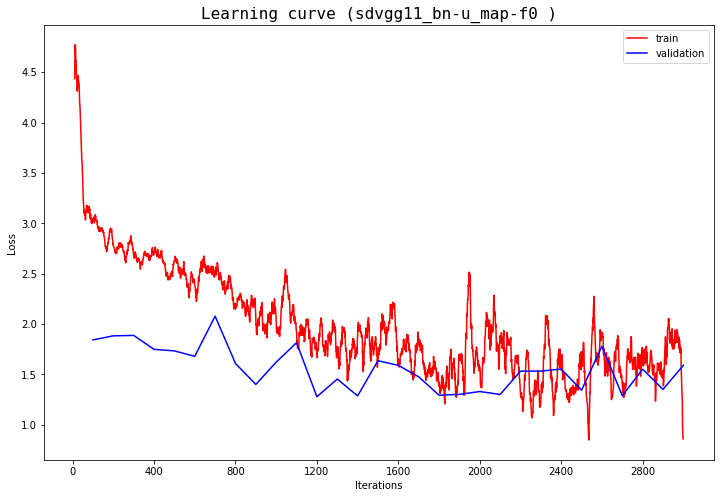

In [27]:
from plotting.learning_curves import loss_plot
# exp_hdl_emap, exp_hdl_no_emap, exp_hdl_umap, exp_hdl_no_umap

loss_plot(exp_hdl_umap, height=8, width=12, save=False, show=True, validation=True,
              log_scale=False, do_average=True, window_size=25, epoch_range=None)

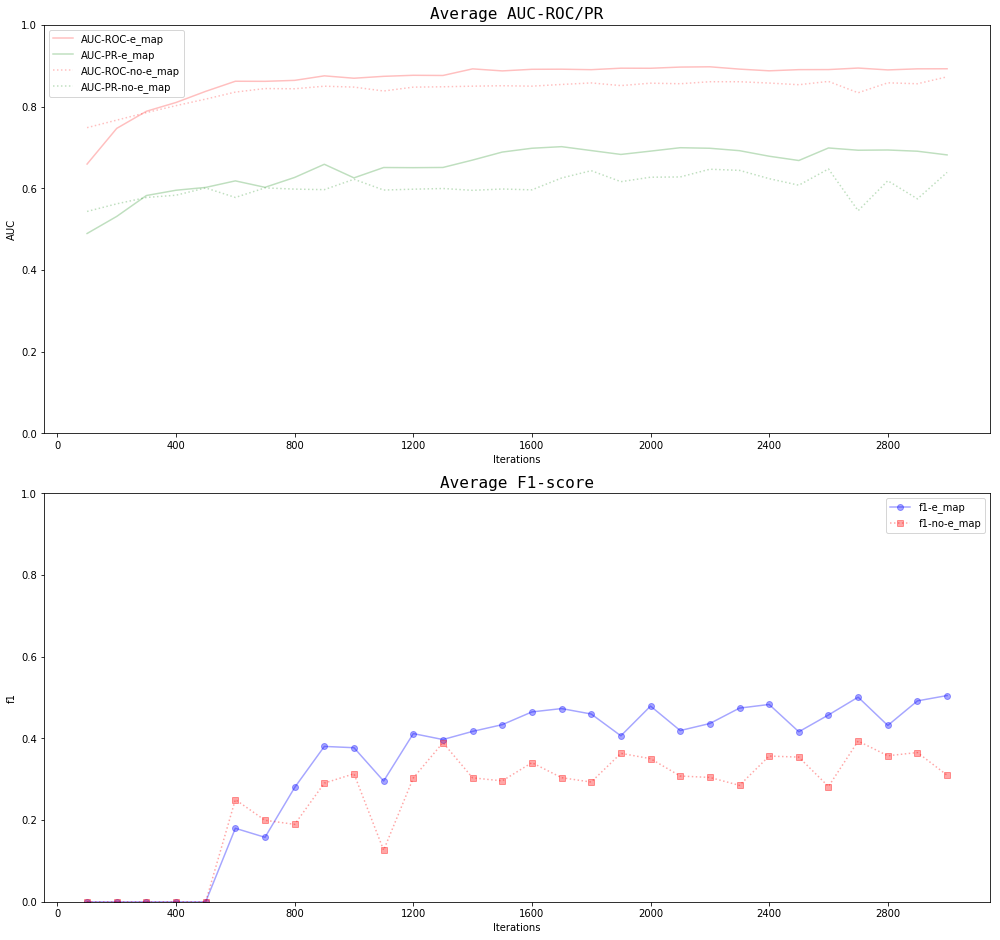

In [36]:
from plotting.dslices.classification_metrics import average_auc
 # 
average_auc(expers, fig_name=None, height=14, width=14, save=False, show=True)

In [5]:
sdvgg = exp_hdl_emap.load_checkpoint(exp_hdl_emap.exper.run_args.log_dir)

Creating new model DegenerateSliceDetector
INFO - model-param spp_pyramid: [4, 2, 1]
INFO - model-param optimizer: adam
INFO - model-param num_of_classes: 2
INFO - model-param fp_penalty_weight: 7.0
INFO - model-param backward_freq: 10
INFO - model-param base_model: vgg11_bn
INFO - model-param weight_decay: 5.0
INFO - model-param drop_percentage: 0.5
Loading existing model with checkpoint 3000 from dir /home/jorg/repository/dcnn_acdc/logs/20180829_17_45_49_sdvgg11_bn_f0p01_brier_emap_3KE_lr1e04/checkpoints


In [6]:
detect_dataset = create_dataset(exp_hdl_emap, seg_exper_ensemble, type_of_map="e_map", degenerate_type="mean", 
                                pos_label=1, overwrite_quick_run=True)


 33%|███▎      | 1/3 [00:00<00:00,  7.10it/s]

INFO - Using folds [0] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images_iso_test/*patient*.mhd <<<


 25%|██▌       | 1/4 [00:00<00:00,  8.62it/s]

INFO - Using folds [0] - loaded 8 files: 3 studies in train set, 1 studies in validation set
INFO - Mean width/height/#slices per image 218/271/11
---------------------- Image incompleteness statistics -------------------------
ES: slices missing RV/MYO/LV 0/0/0 (0.00/0.00/0.00) / complete 0 wo-all 0
ED: slices missing RV/MYO/LV 0/0/0 (0.00/0.00/0.00) / complete 0 wo-all 0
INFO - Loading referral results for thresholds [0.001]


100%|██████████| 4/4 [00:00<00:00,  9.23it/s]

INFO - Patients with degenerate slices train/test 3.0 / 1.0
INFO - #Patients in train/test set 3/1


In [7]:
exp_hdl_emap.test(data_set=detect_dataset, model=sdvgg)

INFO - Begin test run 1
END test run 1 #slices=20 loss 1.089: f1=0.500 - roc_auc=0.970 - pr_auc=0.833 - prec=0.500 - rec=0.500 - 0.14 seconds


In [65]:
test_id = exper_hdl_umaps.last_test_id

precision, recall, thresholds = exper_hdl_umaps.test_stats[test_id]["pr_curve"]
average_precision = exper_hdl_umaps.test_stats[test_id]["pr_auc"]

In [67]:
test_id = exper_hdl_umaps_l1.last_test_id

precision, recall, thresholds = exper_hdl_umaps_l1.test_stats[test_id]["pr_curve"]
average_precision = exper_hdl_umaps_l1.test_stats[test_id]["pr_auc"]

Text(0.5,1,u'2-class Precision-Recall curve: AP=0.96')

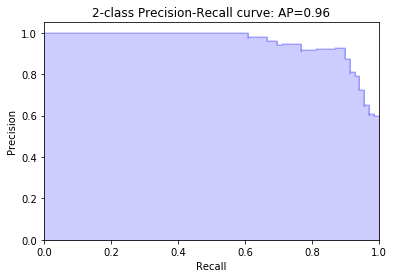

In [68]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))